<a href="https://colab.research.google.com/github/bhanujgunas/quantumautoencoder/blob/main/ibm_torino_qautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Package installation and dataset downloading

In [1]:
!curl -L -o cbis-ddsm.zip https://www.kaggle.com/api/v1/datasets/download/awsaf49/cbis-ddsm-breast-cancer-image-dataset
!unzip -q cbis-ddsm.zip -d CBIS_DDSM


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5072M  100 5072M    0     0  76.3M      0  0:01:06  0:01:06 --:--:-- 74.6M


In [2]:
!pip install torch torchvision torchaudio
!pip install qiskit qiskit-ibm-runtime qiskit-machine-learning
!pip install opencv-python pandas scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 16.6 MB/s eta 0:00:00


2. Import Test

In [3]:
import torch, cv2, qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)
print("Qiskit:", qiskit.__version__)


Torch: 2.9.0+cu126
CUDA available: True
OpenCV: 4.13.0
Qiskit: 2.3.0


3. IBM Credential Saving

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator

QiskitRuntimeService.save_account(
token="rYvbFeN2vWCyjuPArD5bMNXzwsasrzaTgQOwpUFkJrUd", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="qautoencoder", # Optional - instance
overwrite=True)

service = QiskitRuntimeService()
print(service.backends())
backend = service.backend("ibm_torino")
print("Backend:", backend.name)


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]
Backend: ibm_torino


4. Imports & Environment

In [53]:
import os, glob, cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session


5. Global Configuration

In [6]:
ROOT_DIR = "/content/CBIS_DDSM"
IMAGE_SIZE = 256
BATCH_SIZE = 2
EPOCHS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [7]:
metadata = pd.read_csv(f"{ROOT_DIR}/csv/meta.csv")
dicom = pd.read_csv(f"{ROOT_DIR}/csv/dicom_info.csv")

mass_train = pd.read_csv(f"{ROOT_DIR}/csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv(f"{ROOT_DIR}/csv/mass_case_description_test_set.csv")

calc_train = pd.read_csv(f"{ROOT_DIR}/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv(f"{ROOT_DIR}/csv/calc_case_description_test_set.csv")

print("Metadata:",metadata.shape)
print("Dicom:",dicom.shape)
print("Mass train:", mass_train.shape)
print("Mass test:", mass_test.shape)
print("Calc train:", calc_train.shape)
print("Calc test:", calc_test.shape)


Metadata: (6775, 9)
Dicom: (10237, 38)
Mass train: (1318, 14)
Mass test: (378, 14)
Calc train: (1546, 14)
Calc test: (326, 14)


In [8]:
def prepare_df_mass_train(df):
    df = df.copy()

    # pathology label
    df["pathology_final"] = df["pathology"].map({
        "BENIGN": 0,
        "BENIGN_WITHOUT_CALLBACK": 0,
        "MALIGNANT": 1
    })

    # keep only what we need
    keep_cols = [
        "patient_id",
        #"breast_density",
        "left or right breast",
        "image view",
        #"abnormality id",
        #"abnormality type",
        #"mass shape",
        #"mass margins",
        #"assessment",
        #"pathology",
        #"subtlety",
        "image file path",
        "ROI mask file path",
        "pathology_final"
    ]
    return df[keep_cols]

df_mass_train = pd.concat([
    prepare_df_mass_train(mass_train),
    # prepare_df(mass_test, "mass")
], ignore_index=True)

#df = df.dropna(subset=["label"])
print("Total samples:", len(df_mass_train))
df_mass_train.head()


Total samples: 1318


,patient_id,left or right breast,image view,image file path,ROI mask file path,pathology_final
0,P_00001,LEFT,CC,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,1
1,P_00001,LEFT,MLO,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,1
2,P_00004,LEFT,CC,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,0
3,P_00004,LEFT,MLO,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,0
4,P_00004,RIGHT,MLO,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,0


In [51]:
def prepare_df_meta(df):
    df = df.copy()

    # keep only what we need
    keep_cols = [
        "SeriesInstanceUID",
        "StudyInstanceUID",
        #"Modality",
        "SeriesDescription",
        "ImageCount"
    ]
    return df[keep_cols]

df_meta = pd.concat([
    prepare_df_meta(metadata),
], ignore_index=True)

#df = df.dropna(subset=["label"])
print("Total samples:", len(df_meta))
df_meta.head()

Total samples: 6775


,SeriesInstanceUID,StudyInstanceUID,SeriesDescription,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,ROI mask images,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,ROI mask images,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,ROI mask images,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,ROI mask images,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,ROI mask images,2


In [10]:
def prepare_df_dicom(df):
    df = df.copy()
    df.head()
    # keep only what we need

    keep_cols = [
        "file_path",
        "image_path",
        #"BitsAllocated",
        #"BitsStored",
        "BodyPartExamined",
        #"Columns",
        #"ContentDate",
        #"ContentTime",
        #"ConversionType",
        #"HighBit",
        #"LargestImagePixelValue",
        "Laterality",
        #"Modality",
        "PatientID",
        "PatientName",
        "PatientOrientation",
        #"Rows",
        #"SOPClassUID",
        "SOPInstanceUID",
        "SeriesDescription",
        "SeriesInstanceUID",
        #"SmallestImagePixelValue",
        #"StudyDate",
        "StudyInstanceUID",
        #"StudyTime"
    ]
    return df[keep_cols]

df_dicom = pd.concat([
    prepare_df_dicom(dicom),
], ignore_index=True)

print("Total samples:", len(df_dicom))
df_dicom.head(10)

Total samples: 10237


,file_path,image_path,BodyPartExamined,Laterality,PatientID,PatientName,PatientOrientation,SOPInstanceUID,SeriesDescription,SeriesInstanceUID,StudyInstanceUID
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,BREAST,R,Mass-Training_P_01265_RIGHT_MLO_1,Mass-Training_P_01265_RIGHT_MLO_1,MLO,1.3.6.1.4.1.9590.100.1.2.426380754911844882201...,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,BREAST,R,Mass-Training_P_01754_RIGHT_CC,Mass-Training_P_01754_RIGHT_CC,CC,1.3.6.1.4.1.9590.100.1.2.235715018911442345533...,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,BREAST,R,Calc-Training_P_00232_RIGHT_CC,Calc-Training_P_00232_RIGHT_CC,CC,1.3.6.1.4.1.9590.100.1.2.212917405611495375422...,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,BREAST,L,Calc-Test_P_00562_LEFT_CC_2,Calc-Test_P_00562_LEFT_CC_2,CC,1.3.6.1.4.1.9590.100.1.2.405776661412249467913...,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,Left Breast,NaN,P_00562_LEFT_CC_2.dcm,P_00562^P_00562,CC,1.3.6.1.4.1.9590.100.1.2.418434643810489919922...,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...
5,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.15333...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,BREAST,R,Calc-Training_P_00181_RIGHT_CC_1,Calc-Training_P_00181_RIGHT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.265034136111320280631...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...,1.3.6.1.4.1.9590.100.1.2.157384031212566921514...
6,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.15333...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...,BREAST,R,Calc-Training_P_00181_RIGHT_CC_1,Calc-Training_P_00181_RIGHT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.398771175312365272736...,cropped images,1.3.6.1.4.1.9590.100.1.2.153339052913121382622...,1.3.6.1.4.1.9590.100.1.2.157384031212566921514...
7,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.17899...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,BREAST,L,Calc-Training_P_01015_LEFT_CC_1,Calc-Training_P_01015_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.131386567811700111319...,cropped images,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...,1.3.6.1.4.1.9590.100.1.2.250103550412831547020...
8,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.17899...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...,BREAST,L,Calc-Training_P_01015_LEFT_CC_1,Calc-Training_P_01015_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.294915843610022454741...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.178994714611485132105...,1.3.6.1.4.1.9590.100.1.2.250103550412831547020...
9,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.41183...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...,BREAST,L,Calc-Training_P_01497_LEFT_CC_1,Calc-Training_P_01497_LEFT_CC_1,CC,1.3.6.1.4.1.9590.100.1.2.318779025102243592402...,ROI mask images,1.3.6.1.4.1.9590.100.1.2.411833492612373627114...,1.3.6.1.4.1.9590.100.1.2.407544576612957992910...


Cropped Image: 3567
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object


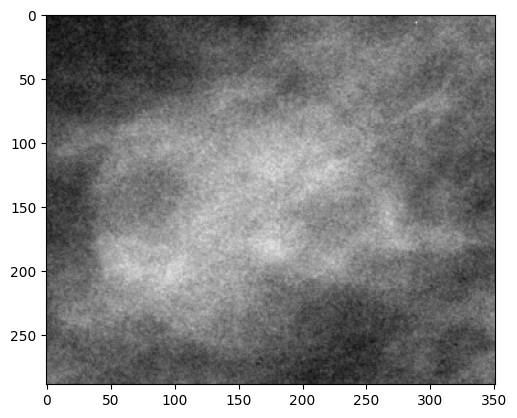

In [42]:
cropped_images=df_dicom[df_dicom.SeriesDescription == 'cropped images'].image_path
print("Cropped Image:",len(cropped_images))
print(cropped_images[0])
print(cropped_images.head())
cropped_img_show = PIL.Image.open(ROOT_DIR+cropped_images[0].strip("CBIS-DDSM"))
gray_img= cropped_img_show.convert("L")
plt.imshow(cropped_img_show, cmap='gray')


Full Mammography Image: 2857
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object


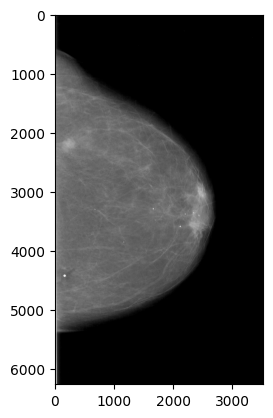

In [47]:
full_mammography_images=df_dicom[df_dicom.SeriesDescription == 'full mammogram images'].image_path
print("Full Mammography Image:",len(full_mammography_images))
print(full_mammography_images[1])
print(full_mammography_images.head())
full_img_show = PIL.Image.open(ROOT_DIR+full_mammography_images[1].strip("CBIS-DDSM"))
gray_img= full_img_show.convert("L")
plt.imshow(gray_img, cmap='gray')

ROI Mask Image: 3247
CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg
5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object


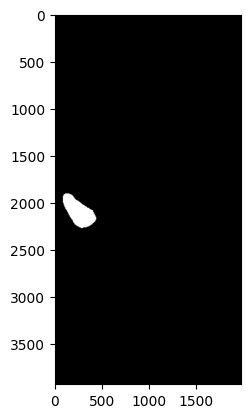

In [49]:
roi_mask_images=df_dicom[df_dicom.SeriesDescription == 'ROI mask images'].image_path
print("ROI Mask Image:",len(roi_mask_images))
print(roi_mask_images[5])
print(roi_mask_images.head())
roi_mask_show = PIL.Image.open(ROOT_DIR+roi_mask_images[5].strip("CBIS-DDSM"))
gray_img= roi_mask_show.convert("L")
plt.imshow(gray_img, cmap='gray')

In [52]:
r= pd.DataFrame(dicom['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3567
1,ROI mask images,3247
2,full mammogram images,2857


In [55]:
q= pd.DataFrame(dicom['PatientOrientation'].value_counts())
q= q.reset_index()
q= q.rename(columns={'PatientOrientation':'PatientOrientation_counts', 'index':'PatientOrientation'})
q

,PatientOrientation_counts,count
0,MLO,5434
1,CC,4803


In [56]:
f= pd.DataFrame(dicom['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248
